# 0. Install Dependencies and Bring in Data

In [5]:
# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [7]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.1.0
aiofiles                  23.2.1
altair                    5.3.0
annotated-types           0.7.0
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.15.0
beautifulsoup4            4.12.3
bleach                    6.1.0
blinker                   1.8.2
certifi                   2024.6.2
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.1
decorator                 5.1.1
defusedxml                0.7.1
dnspython                 2.6.1
email_validator   

In [8]:
from tensorflow.keras.layers import TextVectorization

In [9]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [10]:
MAX_FEATURES = 200000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorized_text = vectorizer(X.values)

In [14]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [15]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [17]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [18]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train, epochs=1, validation_data=val)

3639/6981 ━━━━━━━━━━━━━━━━━━━━ 1:01:55 1s/step - loss: 0.1003

In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

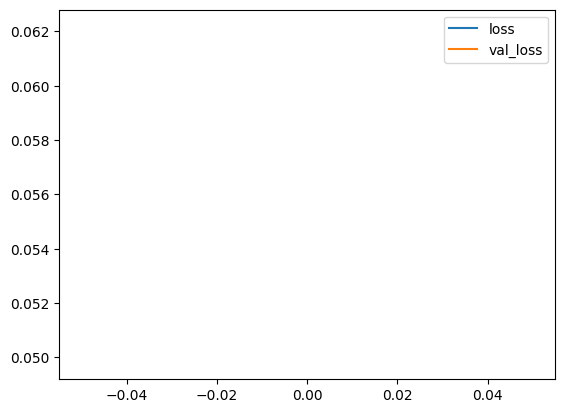

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
input_text = tf.expand_dims(input_text, 0)
res = model.predict(input_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


In [ ]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
df.columns[2:]

NameError: name 'df' is not defined

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
res.shape

(1, 6)

# 4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/s

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7456961870193481, Recall:0.7447963953018188, Accuracy:0.47843530774116516


# 5. Test and Gradio

In [ ]:
%pip install gradio jinja2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached huggingface_hub-0.23.4-py3-none-any.whl.metadata (12 kB)
     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     ---------------------------------------- 50.9/50.9 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/109.4 kB ? eta -:--:--
     -------------------------------------- 109.4/109.4 kB 3.1 MB/s eta 0:00:00
  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.3 MB 9.4 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/12.3 MB 8.8 MB/s eta 0:00:02
   -- ------------------------------------- 0.9/12.3 MB 7.0 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/12.3 MB 6.1 MB/s eta 0:00:02
   --- ------------

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.keras')

NameError: name 'model' is not defined

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

NameError: name 'model' is not defined

In [ ]:
res

array([[0.80014956, 0.03019641, 0.42429352, 0.0347546 , 0.35149086,
        0.0783052 ]], dtype=float32)

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.components.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

NameError: name 'interface' is not defined